## Phylogeny of datasets

### Minhash phylogeny - Sourmash

### Testing

##### making sketches

In [1]:
import sourmash
seq1 = "ATGGCA"
seq2 = "AGAGCA"

mh1 = sourmash.MinHash(n=0, ksize=3, scaled=1)
mh1.add_sequence(seq1, force=True)

mh2 = sourmash.MinHash(n=0, ksize=3, scaled=1)
mh2.add_sequence(seq2, force=True)

In [2]:
mh1.jaccard(mh1)

1.0

### Phage Minhashing 

##### iterating through kmers

In [2]:
import sourmash
from Bio import SeqIO
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"

records = list(SeqIO.parse(raw_data_path+"phagehost_KU/phage_cleaned.fasta", "fasta"))
K = 8

#only first record
print("First record:", records[0].id, len(records[0].seq))
mh1 = sourmash.MinHash(n=0, ksize=K, scaled=1)
for i in range(0, len(records[0].seq) - K + 1):
    kmer = str(records[0].seq[i:i+K])
    mh1.add_sequence(kmer, force=True)
    print(i, kmer, mh1.seq_to_hashes(kmer))

#second record
print("Second record:", records[1].id, len(records[1].seq))
mh2 = sourmash.MinHash(n=0, ksize=K, scaled=1)
for i in range(0, len(records[1].seq) - K + 1):
    kmer = str(records[1].seq[i:i+K])
    mh2.add_sequence(kmer, force=True)
    print(i, kmer, mh2.seq_to_hashes(kmer))

First record: Lelliottia_phage_Pantea 150009
0 AACACATT [10188490277577433374]
1 ACACATTT [4504797084856874129]
2 CACATTTT [1777682080814772753]
3 ACATTTTT [2014857466958517677]
4 CATTTTTC [16301636214376221781]
5 ATTTTTCC [3361171682012701449]
6 TTTTTCCC [8957579627478337008]
7 TTTTCCCT [5002931861691839811]
8 TTTCCCTC [9574187947670333648]
9 TTCCCTCT [6874908743334655258]
10 TCCCTCTG [16525319189085943558]
11 CCCTCTGT [12403511297437692480]
12 CCTCTGTG [1217962557789596750]
13 CTCTGTGT [7785750153134198161]
14 TCTGTGTC [1893924296737055879]
15 CTGTGTCA [11492813152352140903]
16 TGTGTCAA [11588748244833617727]
17 GTGTCAAG [9500913623314344341]
18 TGTCAAGC [1518746145029783820]
19 GTCAAGCT [17790443054010490988]
20 TCAAGCTT [16346532495423286225]
21 CAAGCTTT [2468076128661865304]
22 AAGCTTTT [7686609832814149288]
23 AGCTTTTT [13694003111474242535]
24 GCTTTTTG [1148151723049418363]
25 CTTTTTGT [6839079944671866015]
26 TTTTTGTG [12867697776180589810]
27 TTTTGTGG [6697056452540310897]
28 

Comparing sketches of mh1 and mh2

In [3]:
from tqdm import tqdm

#Constructing minhashes for all records
minhashes = []
for rec in tqdm(records, desc="Constructing minhashes for all records", unit="seq"):
    #print("Record:", rec.id, len(rec.seq))
    mh = sourmash.MinHash(n=0, ksize=K, scaled=1) #each record gets its own minhash
    for i in range(0, len(rec.seq) - K + 1):
        kmer = str(rec.seq[i:i+K])
        mh.add_sequence(kmer, force=True)
    minhashes.append(mh)

#Comparing all minhashes
similarity_matrix = dict()
for i, e in enumerate(minhashes):
    sim_inner = dict()
    for j, e2 in enumerate(minhashes):
        x = e.jaccard(minhashes[j])
        sim_inner[records[j].id.split("_")[-1]] = x
    similarity_matrix[records[i].id.split("_")[-1]] = sim_inner

Constructing minhashes for all records: 100%|██████████| 23/23 [00:02<00:00,  9.10seq/s]


### Converting all phage genomes to sketches and saving

In [2]:
from tqdm import tqdm
from Bio import SeqIO
import sourmash, sys, os
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"
K = 12 #kmer size in nucleotides 

records = list(SeqIO.parse(raw_data_path+"phagehost_KU/phage_cleaned.fasta", "fasta"))

#Constructing minhashes for all records
minhashes = []
phage_names = []
for rec in tqdm(records, desc="Constructing minhashes for all records", unit="seq"):
    #print("Record:", rec.id, len(rec.seq))
    mh = sourmash.MinHash(n=500000, ksize=K, scaled=0) #each record gets its own minhash | scaled=1000 to limit 
    for i in range(0, len(rec.seq) - K + 1):
        kmer = str(rec.seq[i:i+K])
        mh.add_sequence(kmer, force=True)
    minhashes.append(mh)
    phage_names.append(rec.id.split("_")[-1])

if len(minhashes) != len(records):
    print("Warning: Number of minhashes does not match number of records!")
    sys.exit(1)

#Comparing all minhashes
similarity_matrix = dict()
for i, e in enumerate(minhashes):
    sim_inner = dict()
    for j, e2 in enumerate(minhashes):
        x = e.jaccard(minhashes[j])
        sim_inner[records[j].id] = x
    similarity_matrix[records[i].id] = sim_inner

#Creating output directory
if not os.path.exists(data_prod_path+f"phage_minhash_{K}/"):
    os.makedirs(data_prod_path+f"phage_minhash_{K}/")

#Saving sketches
for i in range(len(minhashes)):
    with open(data_prod_path+f"phage_minhash_{K}/{phage_names[i]}.sig", "wt") as sigfile:
        sig1 = sourmash.SourmashSignature(minhashes[i], name=phage_names[i])
        sourmash.save_signatures([sig1], sigfile)

Constructing minhashes for all records:   0%|          | 0/23 [00:00<?, ?seq/s]

Constructing minhashes for all records: 100%|██████████| 23/23 [00:05<00:00,  4.41seq/s]


#### Plotting similarity as heatmap

<Axes: title={'center': 'MinHash Similarity of Phages 8mer'}>

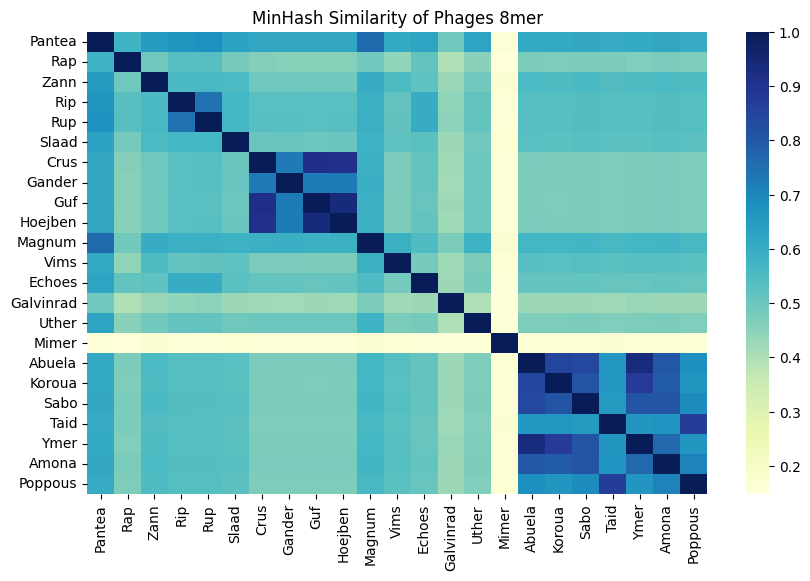

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(similarity_matrix)
fig = plt.figure(figsize=(10,6))
plt.title(f"MinHash Similarity of Phages {K}mer")
sns.heatmap(df, cmap="YlGnBu")

<Axes: title={'center': 'MinHash Similarity of Selected Phage Cluster 8mer'}>

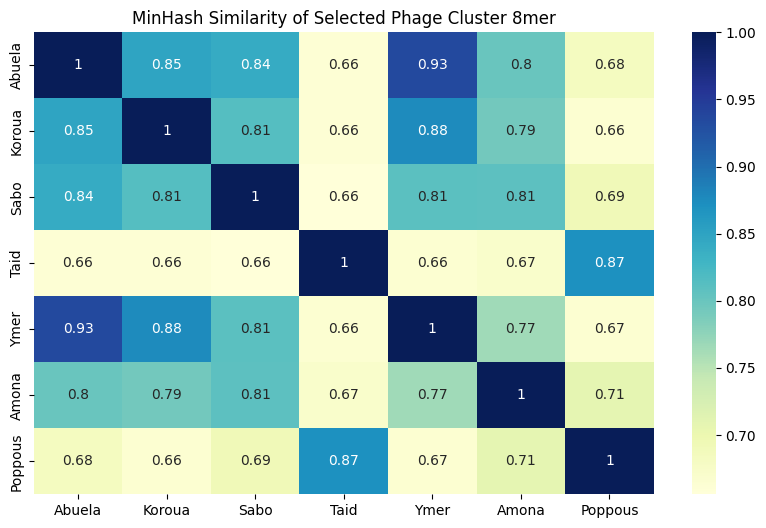

In [7]:
selected_phages = ["Abuela", "Koroua", "Sabo", "Taid", "Ymer", "Amona", "Poppous"]

fig = plt.figure(figsize=(10,6))
plt.title(f"MinHash Similarity of Selected Phage Cluster {K}mer")
sns.heatmap(df[df.index.isin(selected_phages)][selected_phages], cmap="YlGnBu", annot=True)

### Bacteria Minhashing

##### Constructing signatures using manipulations.py

In [3]:
import os, sys 
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"

from manipulations import construct_SM_sketches
construct_SM_sketches(fasta = raw_data_path+"phagehost_KU/bacteriaKU_cleaned.fasta", 
                      k = 30, 
                      outdir = data_prod_path+"BactMinhash/", 
                      quiet = False)

Created output directory: ../data_prod/BactMinhash/


TypeError: '>' not supported between instances of 'list' and 'int'

##### [OLD WAY] iterating through kmers

Comparing sketches of mh1 and mh2

In [8]:
from Bio import SeqIO
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"

records = list(SeqIO.parse(raw_data_path+"phagehost_KU/bacteriaKU_cleaned.fasta", "fasta"))
K = 37

In [9]:
from tqdm import tqdm

#Constructing minhashes for all records
minhashes = []
for rec in tqdm(records, desc="Constructing minhashes for all records", unit="seq"):
    #print("Record:", rec.id, len(rec.seq))
    mh = sourmash.MinHash(n=500000, ksize=K, scaled=0) #each record gets its own minhash | scaled=1000 to limit 
    for i in range(0, len(rec.seq) - K + 1):
        kmer = str(rec.seq[i:i+K])
        mh.add_sequence(kmer, force=True)
    minhashes.append(mh)

#Comparing all minhashes
similarity_matrix = dict()
for i, e in enumerate(minhashes):
    sim_inner = dict()
    for j, e2 in enumerate(minhashes):
        x = e.jaccard(minhashes[j])
        sim_inner[records[j].id] = x
    similarity_matrix[records[i].id] = sim_inner

Constructing minhashes for all records:   1%|          | 3/280 [01:06<1:43:06, 22.33s/seq]


KeyboardInterrupt: 

In [ ]:
#Saving sketches
for i in range(len(minhashes)):
    with open(data_prod_path+f"bact_minhash_37/bact{i}.sig", "wt") as sigfile:
        sig1 = sourmash.SourmashSignature(minhashes[i], name=records[i].id)
        sourmash.save_signatures([sig1], sigfile)

### Working with signatures

In [11]:
import sourmash, os, sys
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"
minhashes = []
sig_dir = data_prod_path+"bact_minhash_37/"
print("Number of signatures", len(os.listdir(sig_dir)))

"""
### Loading sigs - individually
for file in os.listdir(sig_dir):
    try:
        single_sig = sourmash.load_one_signature(sig_dir+file)
        print(single_sig)
    except: #catching wrongful load of signatures
        print(f"Failed to load {file}, now exiting")
        sys.exit(1)
    minhashes.append(single_sig)
"""

### Loading sigs - collectively
loaded_sigs = list(sourmash.load_file_as_signatures(sig_dir))
#print(loaded_sigs[0])

Number of signatures 280


Calculating the jaccard similarity

In [12]:
from tqdm import tqdm
import numpy as np

num_sigs = len(loaded_sigs)
count_zero_jac = 0
count_nonzero_jac = 0
jac_matrix = np.zeros((num_sigs, num_sigs))

for i in tqdm(range(num_sigs), desc="Iterating through loaded sigs (Outer loop)", unit="sigs"):
    for j in range(num_sigs):
        jac = loaded_sigs[i].jaccard(loaded_sigs[j])
        if jac > 0:
            jac_matrix[i, j] = jac
            count_nonzero_jac += 1
        else:
            #no need to add at jac_matrix, as it is already filled with zeros
            count_zero_jac += 1

print(f"Jaccard sim above 0 vs at zero: {count_nonzero_jac}/{count_zero_jac}")

Iterating through loaded sigs (Outer loop): 100%|██████████| 280/280 [03:32<00:00,  1.32sigs/s]

Jaccard sim above 0 vs at zero: 20758/57642


In [13]:
#print([l.minhash.hashes.keys() for l in loaded_sigs])

bact_names = []
for i in range(num_sigs):
    #print(str(loaded_sigs[i]), type(loaded_sigs[i]))
    bact_names.append(str(loaded_sigs[i]))

for name in bact_names:
    print(name, type(name))

J1_21_reoriented <class 'str'>
J1_21_reoriented <class 'str'>
J96_22_reoriented <class 'str'>
J91_22_reoriented <class 'str'>
J91_22_reoriented <class 'str'>
J106_22_reoriented <class 'str'>
J106_22_reoriented <class 'str'>
J106_22_reoriented <class 'str'>
J106_22_reoriented <class 'str'>
J25_21_reoriented <class 'str'>
J2_21_reoriented <class 'str'>
J2_21_reoriented <class 'str'>
J2_21_reoriented <class 'str'>
J96_22_reoriented <class 'str'>
J73_21_reoriented <class 'str'>
J73_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J96_22_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J15_21_reoriented <class 'str'>
J95_22_reoriented <class 'str'>
J2264_1_22_KMC_reoriented <class 'str'>
J2264_1_22_KMC_reoriented <class 

#### Plotting raw similarity as heatmap

J1_21_reoriented  J1_21_reoriented  \
J1_21_reoriented                   1.000000          0.000002   
J1_21_reoriented                   0.000002          1.000000   
J96_22_reoriented                  0.000000          0.000000   
J91_22_reoriented                  0.000004          0.684388   
J91_22_reoriented                  0.000000          0.000000   
...                                     ...               ...   
J39_21_reoriented                  0.000818          0.000016   
J3009_1_22_KMC_reoriented          0.000844          0.000022   
J11_21_reoriented                  0.000804          0.000000   
J11_21_reoriented                  0.000000          0.000000   
J91_22_reoriented                  0.467814          0.000258   

                           J96_22_reoriented  J91_22_reoriented  \
J1_21_reoriented                    0.000000           0.000004   
J1_21_reoriented                    0.000000           0.684388   
J96_22_reoriented                   1.000000           0.000000   
J91_22_reoriented                   0.000000           1.000000   
J91_22_reoriented                   0.000000           0.000000   
...                                      ...                ...   
J39_21_reoriented                   0.000092           0.000016   
J3009_1_22_KMC_reoriented           0.000000           0.000000   
J11_21_reoriented                   0.000140           0.000000   
J11_21_reoriented                   0.000000           0.000000   
J91_22_reoriented                   0.000000           0.000262   

                           J91_22_reoriented  J106_22_reoriented  \
J1_21_reoriented                    0.000000            0.000000   
J1_21_reoriented                    0.000000            0.000000   
J96_22_reoriented                   0.000000            0.000000   
J91_22_reoriented                   0.000000            0.000000   
J91_22_reoriented                   1.000000            0.000000   
...                                      ...                 ...   
J39_21_reoriented                   0.000000            0.000000   
J3009_1_22_KMC_reoriented           0.000000            0.000002   
J11_21_reoriented                   0.000000            0.000008   
J11_21_reoriented                   0.000000            0.000000   
J91_22_reoriented                   0.000166            0.000000   

                           J106_22_reoriented  J106_22_reoriented  \
J1_21_reoriented                     0.000000            0.000000   
J1_21_reoriented                     0.000000            0.000000   
J96_22_reoriented                    0.000132            0.001379   
J91_22_reoriented                    0.000000            0.000000   
J91_22_reoriented                    0.000000            0.000000   
...                                       ...                 ...   
J39_21_reoriented                    0.000004            0.000000   
J3009_1_22_KMC_reoriented            0.000004            0.000000   
J11_21_reoriented                    0.000018            0.000006   
J11_21_reoriented                    0.000000            0.000000   
J91_22_reoriented                    0.000000            0.000000   

                           J106_22_reoriented  J25_21_reoriented  ...  \
J1_21_reoriented                     0.000816           0.000838  ...   
J1_21_reoriented                     0.000000           0.000000  ...   
J96_22_reoriented                    0.003050           0.000000  ...   
J91_22_reoriented                    0.000000           0.000000  ...   
J91_22_reoriented                    0.000000           0.000000  ...   
...                                       ...                ...  ...   
J39_21_reoriented                    0.030360           0.030310  ...   
J3009_1_22_KMC_reoriented            0.025078           0.105448  ...   
J11_21_reoriented                    0.030700           0.030280  ...   
J11_21_reoriented                    0.000000           0.000000 

([], [])

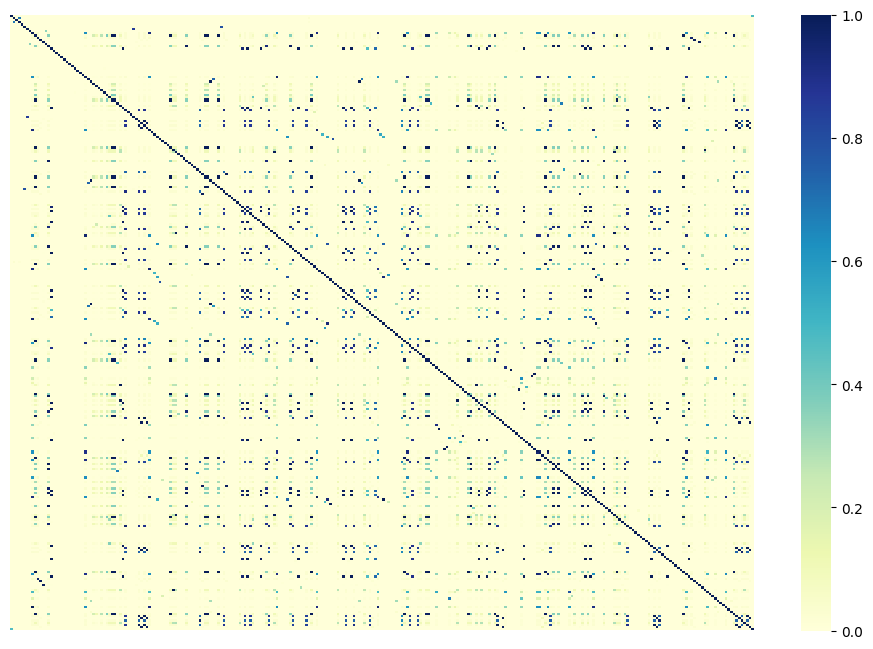

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sim_bact_df = pd.DataFrame(jac_matrix)
sim_bact_df.columns = bact_names
sim_bact_df.index = bact_names
display(sim_bact_df)

plt.figure(figsize=(12,8))
sns.heatmap(sim_bact_df, cmap="YlGnBu")
plt.xticks([], [])
plt.yticks([], [])

#### Similarity plot ordered by family
Lookup ids in excel file

In [15]:
hostrange_pdf = pd.read_excel(raw_data_path+"phagehost_KU/Hostrange_data_all_crisp_iso.xlsx", sheet_name="sum_hostrange", header=1)
id_lookup_bact = hostrange_pdf.set_index("Seq ID")["Species"] #fasta seq IDs + bacteria species lookup
sim_bact_df = sim_bact_df.join(id_lookup_bact, how="left")
sim_bact_df["Species"] #Species is now in sim_bact_df columns
sim_bact_df.loc['Species'] = list(sim_bact_df["Species"].values)+["NA"] # Add 'Species' as a row at the bottom of sim_bact_df

Sort index based on Species

In [16]:
sim_bact_sorted_df = sim_bact_df.sort_values(by="Species", axis=0)
sim_bact_sorted_df["Species"]

J53_21_reoriented     Acinetobacter calcoaceticus
J53_21_reoriented     Acinetobacter calcoaceticus
J14_21_reoriented     Acinetobacter calcoaceticus
J105_22_reoriented                    Chishuiella
J105_22_reoriented                    Chishuiella
                                 ...             
J5_21_reoriented                       Vagococcus
J5_21_reoriented                       Vagococcus
J5_21_reoriented                       Vagococcus
J5_21_reoriented                       Vagococcus
J5_21_reoriented                       Vagococcus
Name: Species, Length: 281, dtype: object

In [17]:
sim_bact_sorted_df

J1_21_reoriented J1_21_reoriented J96_22_reoriented  \
J53_21_reoriented          0.000046              0.0               0.0   
J53_21_reoriented               0.0              0.0               0.0   
J14_21_reoriented          0.000046              0.0               0.0   
J105_22_reoriented          0.00001              0.0               0.0   
J105_22_reoriented              0.0              0.0               0.0   
...                             ...              ...               ...   
J5_21_reoriented                0.0              0.0               0.0   
J5_21_reoriented                0.0              0.0               0.0   
J5_21_reoriented                0.0              0.0               0.0   
J5_21_reoriented                0.0              0.0               0.0   
J5_21_reoriented           0.000012              0.0               0.0   

                   J91_22_reoriented J91_22_reoriented J106_22_reoriented  \
J53_21_reoriented                0.0               0.0                0.0   
J53_21_reoriented                0.0               0.0                0.0   
J14_21_reoriented                0.0               0.0                0.0   
J105_22_reoriented               0.0               0.0                0.0   
J105_22_reoriented               0.0               0.0                0.0   
...                              ...               ...                ...   
J5_21_reoriented                 0.0               0.0                0.0   
J5_21_reoriented                 0.0               0.0                0.0   
J5_21_reoriented                 0.0               0.0                0.0   
J5_21_reoriented                 0.0               0.0                0.0   
J5_21_reoriented                 0.0               0.0                0.0   

                   J106_22_reoriented J106_22_reoriented J106_22_reoriented  \
J53_21_reoriented                 0.0                0.0           0.000036   
J53_21_reoriented                 0.0                0.0                0.0   
J14_21_reoriented                 0.0                0.0           0.000036   
J105_22_reoriented                0.0                0.0           0.000008   
J105_22_reoriented                0.0                0.0                0.0   
...                               ...                ...                ...   
J5_21_reoriented                  0.0                0.0                0.0   
J5_21_reoriented                  0.0                0.0                0.0   
J5_21_reoriented                  0.0                0.0                0.0   
J5_21_reoriented                  0.0                0.0                0.0   
J5_21_reoriented                  0.0                0.0           0.000008   

                   J25_21_reoriented  ... J2264_3_22_KMC_reoriented  \
J53_21_reoriented           0.000038  ...                  0.000004   
J53_21_reoriented                0.0  ...                       0.0   
J14_21_reoriented           0.000038  ...                  0.000004   
J105_22_reoriented          0.000008  ...                   0.00012   
J105_22_reoriented               0.0  ...                       0.0   
...                              ...  ...                       ...   
J5_21_reoriented                 0.0  ...                       0.0   
J5_21_reoriented                 0.0  ...                       0.0   
J5_21_reoriented                 0.0  ...                       0.0   
J5_21_reoriented                 0.0  ...                       0.0   
J5_21_reoriented            0.000008  ...                  0.000006   

                   J20_21_reoriented J6_21_reoriented J6_21_reoriented  \
J53_21_reoriented           0.000038          0.00005              0.0   
J53_21_reoriented                0.0              0.0              0.0   
J14_21_reoriented           0.000038         0.000044              0.0   
J105_22_reoriented          0.000008         0.000008              0.0   
J105_22_reoriented               

Sort columns based on Species

In [18]:
display(id_lookup_bact)

Seq ID
J10_21_reoriented                Pectobacterium atrosepticum
J119_23_reoriented                Pectobacterium brasiliense
J11_21_reoriented                Pectobacterium atrosepticum
J126_23_reoriented               Pectobacterium atrosepticum
J127_23_reoriented                Pectobacterium brasiliense
                                       ...                  
2024_jsp                2024 + Julie Stenberg Pedersen (jsp)
march_2023_jsp         2023 + Julier Stenberg Pedersen (jsp)
2022_mmr              2022 + Magnus Mulbjerg Rothgardt (mmr)
2022_mmr_isolation    2022 + Magnus Mulbjerg Rothgardt (mmr)
2022_as_eop                             2022 + Anna Streubel
Name: Species, Length: 126, dtype: object

Transpose to sort again

In [19]:
sim_bact_sorted_df = sim_bact_sorted_df.T
sim_bact_sorted_df = sim_bact_sorted_df.sort_values(by="Species", axis=0)
sim_bact_sorted_df #Columns and index positions match!

J53_21_reoriented J53_21_reoriented J14_21_reoriented  \
J53_21_reoriented                1.0               0.0          0.300544   
J53_21_reoriented                0.0               1.0               0.0   
J14_21_reoriented           0.300544               0.0               1.0   
J105_22_reoriented          0.000008               0.0          0.000008   
J105_22_reoriented               0.0               0.0               0.0   
...                              ...               ...               ...   
J5_21_reoriented                 0.0               0.0               0.0   
J5_21_reoriented                 0.0               0.0               0.0   
J5_21_reoriented                 0.0               0.0               0.0   
J5_21_reoriented                 0.0               0.0               0.0   
J5_21_reoriented            0.000008               0.0          0.000008   

                   J105_22_reoriented J105_22_reoriented J105_22_reoriented  \
J53_21_reoriented            0.000008                0.0                0.0   
J53_21_reoriented                 0.0                0.0                0.0   
J14_21_reoriented            0.000008                0.0                0.0   
J105_22_reoriented                1.0           0.000004           0.000922   
J105_22_reoriented           0.000004                1.0                0.0   
...                               ...                ...                ...   
J5_21_reoriented                  0.0                0.0                0.0   
J5_21_reoriented                  0.0                0.0                0.0   
J5_21_reoriented                  0.0                0.0                0.0   
J5_21_reoriented                  0.0                0.0                0.0   
J5_21_reoriented              0.00001                0.0                0.0   

                   J50_21_reoriented J64_22_reoriented J64_22_reoriented  \
J53_21_reoriented           0.000004          0.000004               0.0   
J53_21_reoriented                0.0               0.0               0.0   
J14_21_reoriented           0.000004          0.000004               0.0   
J105_22_reoriented          0.000118          0.000118               0.0   
J105_22_reoriented               0.0               0.0               0.0   
...                              ...               ...               ...   
J5_21_reoriented                 0.0               0.0               0.0   
J5_21_reoriented                 0.0               0.0               0.0   
J5_21_reoriented                 0.0               0.0               0.0   
J5_21_reoriented                 0.0               0.0               0.0   
J5_21_reoriented            0.000006          0.000006               0.0   

                   J64_22_reoriented  ... J15_21_reoriented J15_21_reoriented  \
J53_21_reoriented                0.0  ...               0.0               0.0   
J53_21_reoriented                0.0  ...               0.0               0.0   
J14_21_reoriented                0.0  ...               0.0               0.0   
J105_22_reoriented               0.0  ...               0.0               0.0   
J105_22_reoriented               0.0  ...               0.0               0.0   
...                              ...  ...               ...               ...   
J5_21_reoriented                 0.0  ...               0.0               0.0   
J5_21_reoriented                 0.0  ...               0.0               0.0   
J5_21_reoriented                 0.0  ...               0.0               0.0   
J5_21_reoriented                 0.0  ...               0.0               0.0   
J5_21_reoriented                 0.0  ...               0.0               0.0   

                   J15_21_reoriented J4_21_reoriented J5_21_reoriented  \
J53_21_reoriented                0.0         0.000046              0.0   
J53_21_reoriented                0.0              0.0              0.0   
J14_21_reoriented                0.0         0.00

Plotting similarity with sorted indexes

Text(0.5, 1.0, 'Similarity of bacterial strains by family with 37mer')

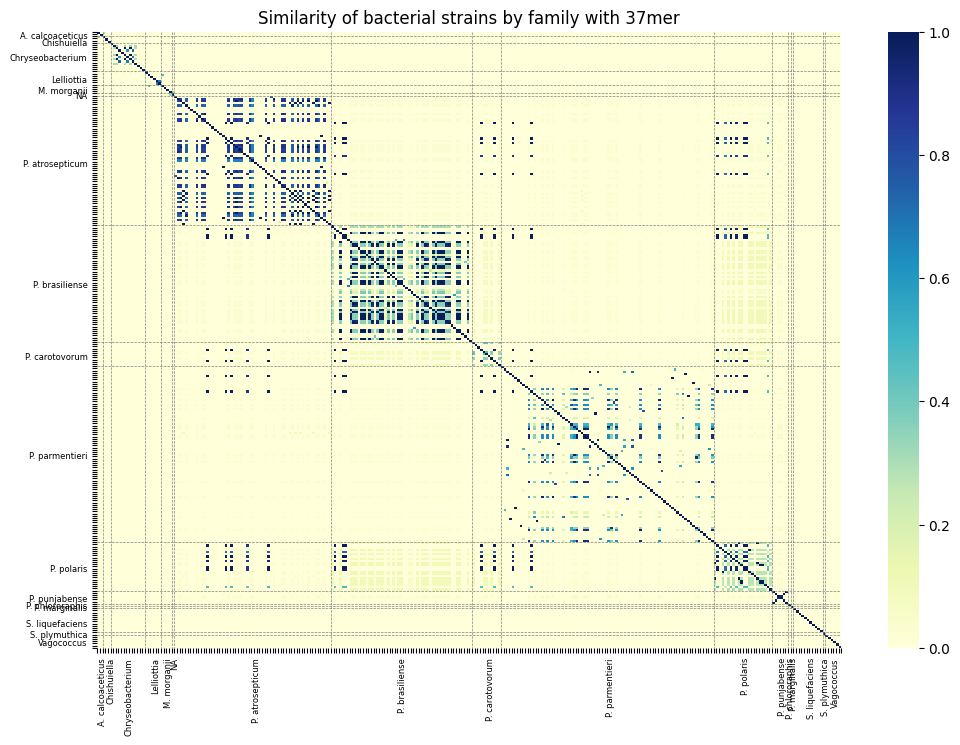

In [22]:
from collections import Counter

def unique_axis_labels(labels):
    counts = Counter(labels)
    l_dict = {}
    for l_uniq in set(labels):
        for i, label in enumerate(labels):
            if l_uniq == label:

                l_dict[l_uniq] = i + round(counts[l_uniq]/2)
                break
    labels_out = ["" for _ in range(len(labels))] #filled with "-" to remove duplicates
    for key, value in l_dict.items():
        labels_out[value] = key
    return labels_out


def reformat_bact_names(bact_names : list):
    new_names = []
    for name in bact_names:
        name_split = name.split(" ")
        if len(name_split) > 1: #two names
            kingdom_abbrev = name.split(" ")[0][0].strip(" ")
            new_names.append(kingdom_abbrev+". "+name.split(" ")[1])
        else:
            new_names.append(name)
    return new_names

### Prepping dataframe (without species)
sim_bact_sorted_df.to_csv(data_prod_path+"sim_bact_sorted_df.csv")
sim_bact_sorted_data_df = sim_bact_sorted_df.drop(index="Species").drop(columns=["Species"])
#display(sim_bact_sorted_data_df)
sim_bact_sorted_data_df = sim_bact_sorted_data_df.astype(float) 

### Making unique labels
labels_abbrev = reformat_bact_names(sim_bact_sorted_df["Species"].values)
labels_unique = unique_axis_labels(labels_abbrev)

plt.figure(figsize=(12,8))
sns.heatmap(sim_bact_sorted_data_df, cmap="YlGnBu")

plt.xticks(
    ticks=range(len(sim_bact_sorted_data_df.index)+1),
    labels=labels_unique,
    rotation=90,
    fontsize=6
    )

plt.yticks(
    ticks=range(len(sim_bact_sorted_data_df.index)+1),
    labels=labels_unique,
    fontsize=6
    )

# Adding y lines for species 
y_labels = sim_bact_sorted_df["Species"].values # Get the species labels for the y-axis
species_change_indices_y = [i for i in range(1, len(y_labels)) if y_labels[i] != y_labels[i-1]] # Find the indices where the species label changes
for idy in species_change_indices_y: # Plot horizontal lines at these indices
    plt.hlines(idy-1, xmin=0, xmax=len(sim_bact_sorted_data_df.columns), colors='grey', linestyles='dashed', linewidth=0.5)

# Adding x lines for species 
x_labels = sim_bact_sorted_df["Species"].values # Get the species labels for the y-axis
species_change_indices_x = [i for i in range(1, len(x_labels)) if x_labels[i] != x_labels[i-1]] # Find the indices where the species label changes
for idx in species_change_indices_x: # Plot horizontal lines at these indices
    plt.vlines(idx-1, ymin=0, ymax=len(sim_bact_sorted_data_df.columns), colors='grey', linestyles='dashed', linewidth=0.5)

plt.title(f"Similarity of bacterial strains by family with {K}mer")

#### Creating Sequence Bloom Tree (SBT) using Sourmash

In [1]:
import sourmash, os, sys
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"
minhashes = []
sig_dir = data_prod_path+"bact_minhash_37/"
print("Number of signatures", len(os.listdir(sig_dir)))

### Initializing tree
import sourmash.sbtmh
tree = sourmash.sbtmh.create_sbt_index()

Number of signatures 280


In [4]:
from sourmash.sbtmh import SigLeaf
for filename in os.listdir(sig_dir):
    sig = sourmash.load_one_signature(sig_dir+filename, ksize=37)
    leaf = SigLeaf(sig.md5sum(), sig)
    tree.add_node(leaf)

filename = tree.save(data_prod_path + '/bact37.sbt.zip')

Finished saving nodes, now saving SBT index file.
Finished saving SBT index, available at /Users/asbjornhansen/PredictPhagePPI/data_prod/bact37.sbt.zip



#### Searching the SBT

In [1]:
import sourmash, os, sys
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"

tree = sourmash.load_file_as_index(data_prod_path + '/bact37.sbt.zip')

In [7]:
### Query a DNA sequence
import screed
filename = raw_data_path + "phagehost_KU/bacteria_fasta/J1_21_reoriented.fna"
query_seq = next(iter(screed.open(filename))).sequence
print(f'got {len(query_seq)} DNA characters to query')

### Creating MinHash for query sequence
K=37
minhash = sourmash.MinHash(ksize=37, n=1000, scaled=0)
minhash.add_sequence(query_seq)

query_sig = sourmash.SourmashSignature(minhash, name='my favorite query')

got 4355796 DNA characters to query


In [8]:
### Searching the SBT
for similarity, found_sig, filename in tree.search(query_sig, threshold=0.1):
   print(query_sig)
   print(found_sig)
   print(similarity)

my favorite query
J1_21_reoriented
1.0
my favorite query
J91_22_reoriented
0.474
my favorite query
J91_22_reoriented
0.474
